In [63]:
from tensorflow.keras import models
from tensorflow.keras import layers
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop

# Plot training & validation accuracy values: https://keras.io/visualization/#training-history-visualization
plt.rcParams['figure.figsize'] = (15.0, 5.0) # set default size of plots

In [143]:
import os
import numpy as np
import random

# fix random seed for reproducibility
seed = 42
tf.random.set_seed(seed)

def set_seeds(seed=seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

set_seeds(42)

In [ ]:
#get consistent results
from keras.models import Sequential
from keras.layers import Dense
import numpy
from numpy.random import seed
seed(42)

In [65]:
# needed to solve the problem with out of GPU memory error 
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

## ALL MODELS RESULTS

## Budowanie sieci

Ponieważ dostępnych jest tak mało próbek, będziemy używać bardzo małej sieci z dwiema ukrytymi warstwami, każda po 32 jednostki. Ogólnie rzecz biorąc, im mniej danych treningowych posiadasz, tym gorsze będzie nadmierne dopasowanie sieci (przeuczenie), a korzystanie z małej sieci jest jednym ze sposobów na złagodzenie nadmiernego dopasowania.

In [66]:
def build_model():
    # Because we will need to instantiate the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(32, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [67]:
from keras import backend as K

# Some memory clean-up
K.clear_session()

### Zadanie

Skopiuj i wklej powyższy kod i spróbuj więcej eksperymentować z dostępnymi hiperparametrami tego modelu, aby osiągnąć jeszcze lepszą wydajność!

In [68]:
from tensorflow.keras import models
from tensorflow.keras import layers
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop

# Plot training & validation accuracy values: https://keras.io/visualization/#training-history-visualization
plt.rcParams['figure.figsize'] = (15.0, 5.0) # set default size of plots

In [69]:
# fix random seed for reproducibility
# seed = 7
# tf.random.set_seed(seed)

In [70]:
import tensorflow as tf
# needed to solve the problem with out of GPU memory error 
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

### Prepare data 

In [71]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

In [72]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

train_data -= mean
train_data /= std

test_data -= mean
test_data /= std

Gdy posiadamy mało danych lepiej jest użyć do uczenia mniejszej sieci (mniej warstw ukrytych) - pozwala to na uniknięcie overfittingu.<br>

In [136]:
def build_model():
    # Because we will need to instantiate the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(32, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

#### K-Fold validation

In [74]:
# num_epochs = 500
def k_fold_validation(model, k, num_epochs):
    all_mae_histories = []
    num_val_samples = len(train_data) // k
    for i in range(k):
        print('processing fold #', i)
        # Prepare the validation data: data from partition # k
        val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

        # Prepare the training data: data from all other partitions
        partial_train_data = np.concatenate(
            [train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]],
            axis=0)
        partial_train_targets = np.concatenate(
            [train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]],
            axis=0)

        # Build the Keras model (already compiled)
        # model = build_model()
        # Train the model (in silent mode, verbose=0)
        history = model.fit(partial_train_data, partial_train_targets,
                            validation_data=(val_data, val_targets),
                            epochs=num_epochs, batch_size=16, verbose=0)
        #print (history.history.keys())
        #mae_history = history.history['val_mean_absolute_error']
        mae_history = history.history['val_mae']
        all_mae_histories.append(mae_history)
    return all_mae_histories

In [75]:
all_mae_histories = {}

In [76]:
model1 = build_model()

In [77]:
print(model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                448       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________
None


In [78]:
all_mae_histories['model1'] = k_fold_validation(model1, 5, 500)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4


In [79]:
def get_avg_mae_histories_per_epoch(model_mae_histories):
    num_epochs = len(model_mae_histories[0])
    average_mae_history = [np.mean([x[i] for x in model_mae_histories])
                           for i in range(num_epochs)]
    argmin = np.argmin(average_mae_history)    
    print(f"argmin: {argmin}")
    print(f"min mae: {average_mae_history[np.argmin(average_mae_history)]}")
    return average_mae_history, argmin

In [80]:
model1_avg_mae, model1_min_mae_epoch = get_avg_mae_histories_per_epoch(all_mae_histories['model1'])

argmin: 39
min mae: 1.4870589971542358


In [133]:
# def smooth_curve(points, factor=0.9):
#   smoothed_points = []
#   for point in points:
#     if smoothed_points:
#       previous = smoothed_points[-1]
#       smoothed_points.append(previous * factor + point * (1 - factor))
#     else:
#       smoothed_points.append(point)
#   return smoothed_points

def plot_model_mae(average_mae_history, argmin):
    # smooth_mae_history = smooth_curve(average_mae_history[10:])
    # omit 10 becuase of different value scale 
    smooth_mae_history = average_mae_history[10:]
    plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
    plt.axvline(x=argmin, color='r', linewidth=2)
    plt.xlabel('Epochs')
    plt.ylabel('Validation MAE')
    plt.show()

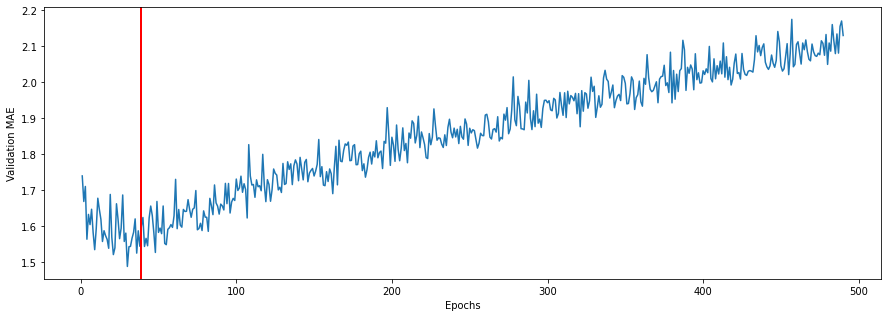

In [134]:
plot_model_mae(model1_avg_mae, model1_min_mae_epoch)

In [83]:
model1_avg_mae[model1_min_mae_epoch]

1.4870589971542358

Na podstawie wykresu można stwierdzić, że ten model przestaje się zbiegać przy epoce o numerze `model_min_mae_epoch` (zaznaczona czerwoną linią) - wtedy wystepuje najnizsza wartosc validation MAE, po tej epoce validation MAE zaczyna wzrastać.

Stworzony zostanie nowy model, który zostanie nauczany przez ilość epok, która dawała najniższą średnią wartość MAE na zbiorze walidacyjnym.

In [144]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
model.fit(train_data, train_targets,
          epochs=model1_min_mae_epoch, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

4/4 [==============================] - 0s 3ms/step - loss: 20.9002 - mae: 3.0518


3.0517890453338623

Model po uczenie przez 39 epok nie daje zadowalających wyników. Sprawdźmy czy jednak przy dłuższym uczeniu jego wyniki się nie polepsza.



In [146]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
model.fit(train_data, train_targets,
          epochs=50, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

4/4 [==============================] - 0s 3ms/step - loss: 22.7989 - mae: 3.0790


3.0790157318115234

Model uczony przez 50 epok daje gorsze wyniki niż ten którego liczba epok jest oparta o wykres MAE na zbiorze walidacyjnym.

Sprawdźmy rezultaty przy 100 epokach.

In [155]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
model.fit(train_data, train_targets,
          epochs=100, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

4/4 [==============================] - 0s 4ms/step - loss: 17.8763 - mae: 2.5644


2.5644309520721436

Mimo tego że najmniejszy błąd na zbiorze walidacyjnym wystąpił na 39 epoce model uczony przez 39 epok działa gorzej niż ten, który uczony został przez 100 epok, co wnioskując po wykresie nie jest do końca oczekiwanym wynikiem. 

Sprawdźmy rezultaty przy 500 epokach.

In [156]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
model.fit(train_data, train_targets,
          epochs=500, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

4/4 [==============================] - 0s 3ms/step - loss: 14.4286 - mae: 2.5519


2.551919937133789

Wynik nieznacznie się zmienił przy 500 epokach - spadła wartość straty, lecz dokładność pozostała praktycznie na tym samym poziomie.


Na podstawie tych obserwacji można stwierdzić że numer epoki, która daje najniższa wartość MAE na zbiorze walidacyjnym nie oznacza jednoznacznie, że jest ona najlepszą opcją. Warto poeksperymentować z ilością epok co pozwoli utworzyć najlepszy model.

Kolejny model jest oparty o model1, dodano do niego jedną warstwę ukrytą zawierającą 32 neurony.

### Model 2

In [157]:
def build_model():
    # Because we will need to instantiate the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(32, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [158]:
model2 = build_model()

In [159]:
print(model2.summary())

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_119 (Dense)           (None, 32)                448       
                                                                 
 dense_120 (Dense)           (None, 32)                1056      
                                                                 
 dense_121 (Dense)           (None, 32)                1056      
                                                                 
 dense_122 (Dense)           (None, 32)                1056      
                                                                 
 dense_123 (Dense)           (None, 1)                 33        
                                                                 
Total params: 3,649
Trainable params: 3,649
Non-trainable params: 0
_________________________________________________________________
None


In [160]:
all_mae_histories['model2'] = k_fold_validation(model2, 5, 500)
model2_avg_mae, model2_min_mae_epoch = get_avg_mae_histories_per_epoch(all_mae_histories['model2'])

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
argmin: 19
min mae: 0.97500439286232


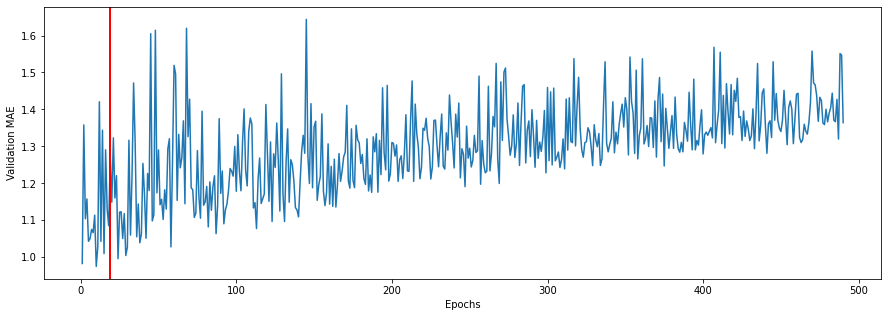

In [161]:
plot_model_mae(model2_avg_mae, model2_min_mae_epoch)

In [162]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
model.fit(train_data, train_targets,
          epochs=model2_min_mae_epoch, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

4/4 [==============================] - 0s 3ms/step - loss: 21.8454 - mae: 3.0973


3.097254753112793

In [163]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

4/4 [==============================] - 0s 3ms/step - loss: 16.9811 - mae: 2.7406


2.7406442165374756

In [170]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
model.fit(train_data, train_targets,
          epochs=250, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

4/4 [==============================] - 0s 5ms/step - loss: 13.2154 - mae: 2.3309


2.3308677673339844

In [165]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
model.fit(train_data, train_targets,
          epochs=500, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

4/4 [==============================] - 0s 4ms/step - loss: 20.4385 - mae: 2.7291


2.7290804386138916

Model 2 osiągnął do tej pory najlepszy wynik z rozpatrywanych konfiguracji. Liczba epok dla której MAE wyniosło 2330$ to 250. (Przeprowadziłem testy dla 80,200, 300, 400, 500, lecz wyniki były gorsze - nie umieściłem ich tutaj, ponieważ zajęłoby to za dużo miejsca).

Na podstawie obserwacji można stwierdzić, że model warto przetestować na różnej ilości epok. Nie tylko tej w otoczeniu najniższego Validation MAE. Aby to zautomatyzować stworzę metodę, która pozwoli zwizualizować wyniki MAE na zbiorze testowym w zależności od ilości epok.  

In [183]:
def plot_MAE_for_epochs(func_build_model: callable, epoch_counts: []):
  results = {}
  for epochs in epoch_counts: 
    # Get a fresh, compiled model.
    model = build_model()
    # Train it on the entirety of the data.
    model.fit(train_data, train_targets,
              epochs=epochs, batch_size=16, verbose=0)
    test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
    results[epochs] = test_mae_score

  # fig = plt.figure(figsize = (10, 5))
  # set bar plot y axis limits 
  min_MAE = min(results.values())
  max_MAE = max(results.values())
  min_y_lim = min_MAE - 0.2 * min_MAE
  max_y_lim = max_MAE + 0.2 * min_MAE
  plt.ylim(min_y_lim, max_y_lim)

  # map list of epochs to strings to make x axis discrete
  epochs_str = list(map(lambda x: str(x), epoch_counts))
  # create  the bar plot
  plt.bar(epochs_str, results.values())
  plt.xlabel("No. of epochs")
  plt.ylabel("Test data MAE")
  plt.show()

4/4 [==============================] - 0s 3ms/step - loss: 14.2584 - mae: 2.5739


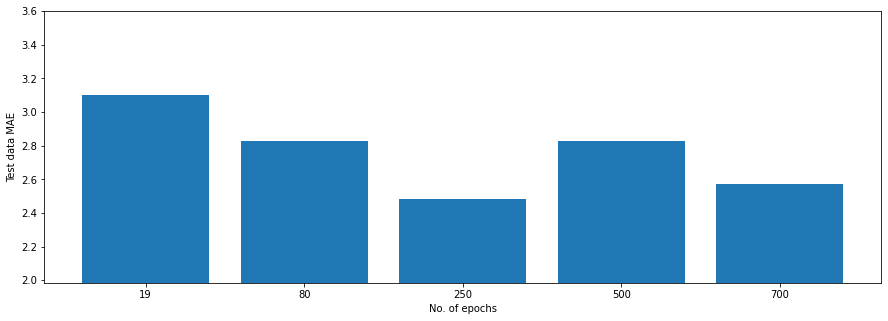

In [185]:
plot_MAE_for_epochs(build_model, [model2_min_mae_epoch, 80, 250, 500, 700])

4/4 [==============================] - 1s 4ms/step - loss: 11.2477 - mae: 2.4985


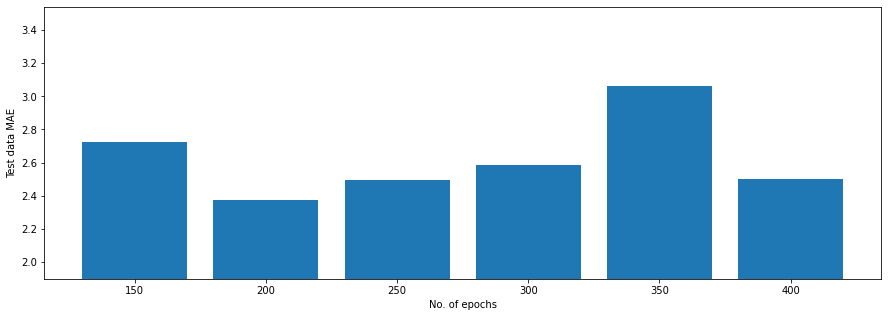

In [186]:
plot_MAE_for_epochs(build_model, [150, 200, 250, 300, 350, 400])

Po kilku próbach widać że najlepszy wynik otrzymujemy ucząc model przez 200 epok, lecz dzięki metodzie która wizualizuje wyniki MAE na zbiorze testowym w łatwy sposób możemy zmniejszyć jeszcze bardziej przedział rozpatrywanych wartości.

4/4 [==============================] - 0s 3ms/step - loss: 15.1974 - mae: 2.6776


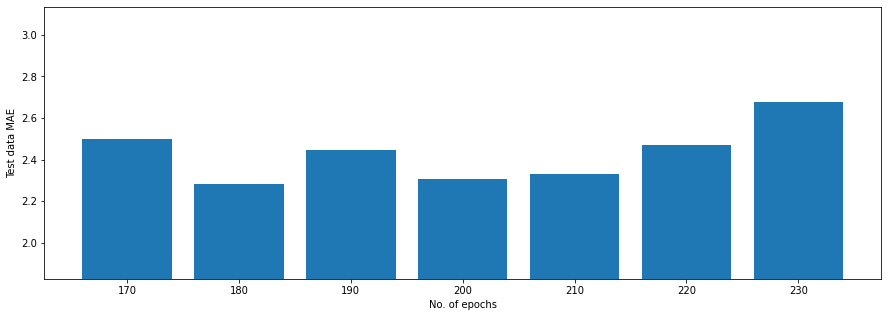

In [187]:
plot_MAE_for_epochs(build_model, [170, 180, 190, 200, 210, 220, 230])

Można uznać że dla tego modelu 180 epok jest optymalnym wyborem. Otrzymujemy wtedy MAE na poziomie ok 2280$.

Pora zacząć zmieniać ilość neuronów w sieci i sprawdzić jakie przyniesie to rezultaty.

### Model 3

In [188]:
def build_model():
    # Because we will need to instantiate the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(128, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(96, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [189]:
model3 = build_model()

In [190]:
print(model3.summary())

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_374 (Dense)           (None, 128)               1792      
                                                                 
 dense_375 (Dense)           (None, 96)                12384     
                                                                 
 dense_376 (Dense)           (None, 64)                6208      
                                                                 
 dense_377 (Dense)           (None, 32)                2080      
                                                                 
 dense_378 (Dense)           (None, 1)                 33        
                                                                 
Total params: 22,497
Trainable params: 22,497
Non-trainable params: 0
_________________________________________________________________
None


In [191]:
all_mae_histories['model3'] = k_fold_validation(model3, 5, 500)
model3_avg_mae, model3_min_mae_epoch = get_avg_mae_histories_per_epoch(all_mae_histories['model3'])

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
argmin: 24
min mae: 0.899832546710968


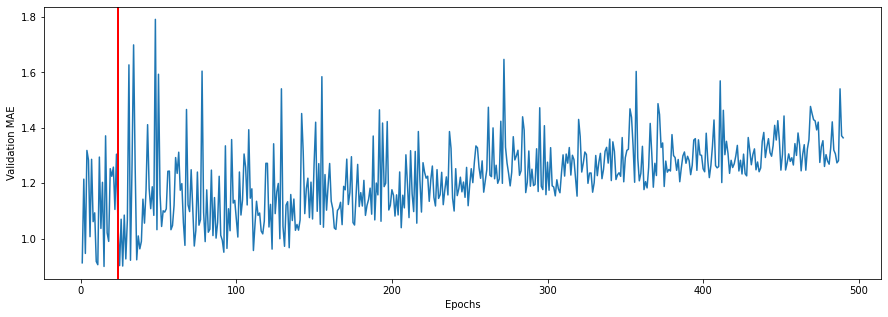

In [192]:
plot_model_mae(model3_avg_mae, model3_min_mae_epoch)

4/4 [==============================] - 0s 4ms/step - loss: 12.6008 - mae: 2.3988


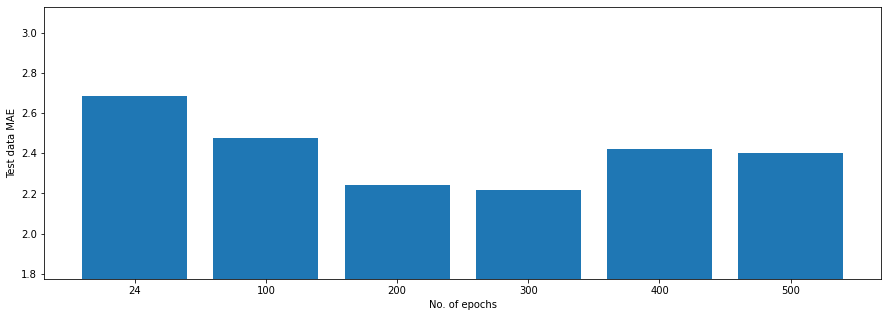

In [222]:
plot_MAE_for_epochs(build_model, [model3_min_mae_epoch, 100, 200, 300, 400, 500])

Najniższa wartość błędu występuje w okolicach 300 epoki. 

Dalsza analiza:

4/4 [==============================] - 0s 3ms/step - loss: 10.7076 - mae: 2.2599


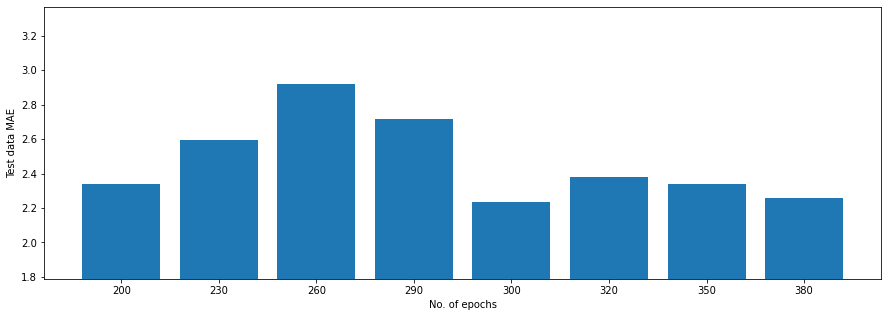

In [219]:
plot_MAE_for_epochs(build_model, [200, 230, 260, 290,300, 320, 350, 380])

Okolice 300 epoki wydają się być najlepszym wyborem. Na diagramie zauważyć też można że przy 200 epoce jest spadek - warto sprawdzić też tamten zakres oraz ponad okolice 380. 

Na podstawie własnych obserwacji podejrzewam, że dobrą opcją może być branie wartości posiadających minimalne wartości MAE na zbiorach walidacyjnych w określonych przedziałach, a nie jednej wartości globalnie na całym zakresie uczenia.


In [205]:
# returns no. of epochs which have the lowest MAE per interval (capacity means how many epochs can interval contain)
def min_MAE_per_interval(mae_history, capacity=50):
  best_epochs_nums = []
  for i in range(len(mae_history) // capacity + 1):
    mae_interval = mae_history[i*capacity:(i+1)*capacity]
    min_mae_num = np.argmin(mae_interval) + i*capacity
    best_epochs_nums.append(min_mae_num)
  return best_epochs_nums

In [220]:
min_MAE_per_interval(model3_avg_mae, 30)

[24,
 36,
 82,
 101,
 120,
 173,
 185,
 215,
 249,
 295,
 328,
 338,
 371,
 394,
 421,
 472,
 487]

4/4 [==============================] - 0s 3ms/step - loss: 17.0688 - mae: 3.1030


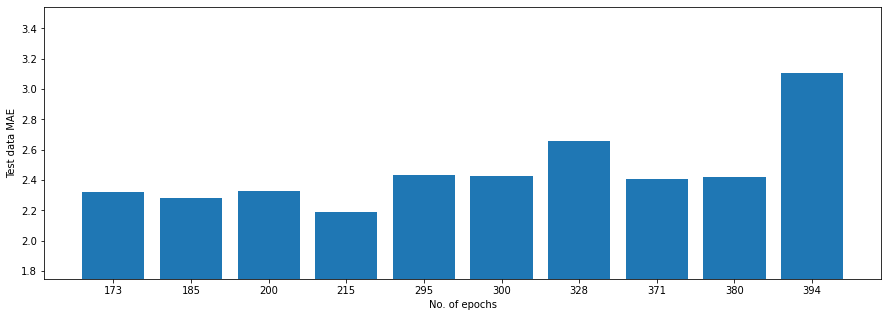

In [221]:
# błędy modeli trenowanych przez wybraną ilość epok z przedziałów: okolice 200, 300 i 380
plot_MAE_for_epochs(build_model,[173, 185, 200, 215, 295, 300, 328, 371, 380, 394])

In [210]:
min_MAE_per_interval(model3_avg_mae, 51)

[24, 101, 120, 173, 215, 258, 328, 371, 421, 472]

4/4 [==============================] - 0s 3ms/step - loss: 11.6247 - mae: 2.2645


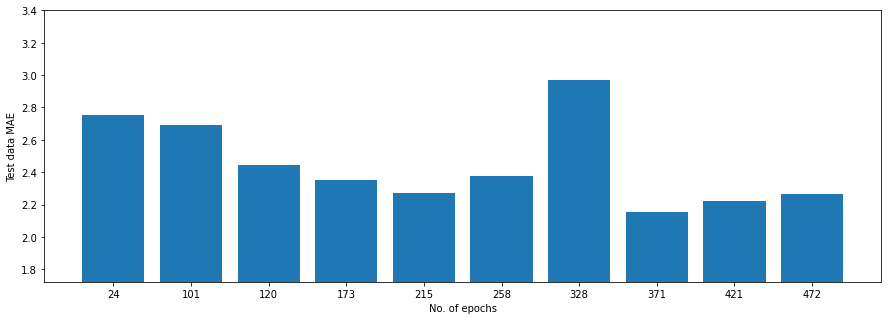

In [214]:
plot_MAE_for_epochs(build_model,[24, 101, 120, 173, 215, 258, 328, 371, 421, 472])

In [ ]:
min_MAE_per_interval(model3_avg_mae, 51)

Finalnie najniższy otrzymany błąd dla tego modelu występuje dla 371 epoki i wynosi 2154$. 

### Model 4

Ten model jest bardzo podobny do poprzedniego. Dodano warstwę wejściową zawierającą 256 neuronów.

In [237]:
def build_model():
    # Because we will need to instantiate the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(256, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(96, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [238]:
model4 = build_model()

In [239]:
print(model4.summary())

Model: "sequential_179"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_895 (Dense)           (None, 256)               3584      
                                                                 
 dense_896 (Dense)           (None, 128)               32896     
                                                                 
 dense_897 (Dense)           (None, 96)                12384     
                                                                 
 dense_898 (Dense)           (None, 64)                6208      
                                                                 
 dense_899 (Dense)           (None, 32)                2080      
                                                                 
 dense_900 (Dense)           (None, 1)                 33        
                                                                 
Total params: 57,185
Trainable params: 57,185
Non-tr

In [240]:
all_mae_histories['model4'] = k_fold_validation(model4, 5, 500)
model4_avg_mae, model4_min_mae_epoch = get_avg_mae_histories_per_epoch(all_mae_histories['model4'])

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
argmin: 19
min mae: 0.8694345355033875


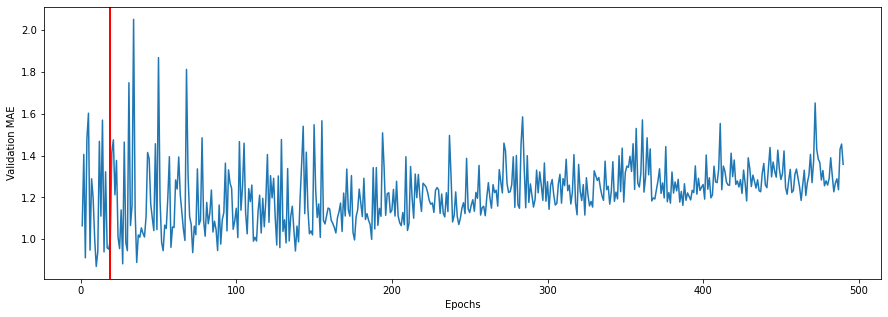

In [241]:
plot_model_mae(model4_avg_mae, model4_min_mae_epoch)

In [242]:
min_MAE_per_interval(model4_avg_mae, 51)

[19, 81, 147, 185, 219, 269, 333, 396, 437, 472]

4/4 [==============================] - 0s 3ms/step - loss: 12.1934 - mae: 2.5078


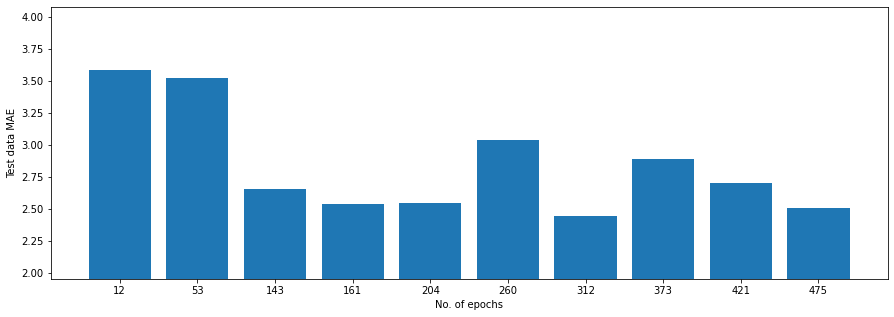

In [235]:
plot_MAE_for_epochs(build_model, [12, 53, 143, 161, 204, 260, 312, 373, 421, 475])

In [244]:
min_MAE_per_interval(model4_avg_mae, 6)

[5,
 10,
 12,
 19,
 24,
 34,
 36,
 45,
 50,
 56,
 62,
 67,
 76,
 81,
 89,
 94,
 97,
 103,
 110,
 116,
 120,
 127,
 137,
 141,
 147,
 153,
 158,
 163,
 173,
 177,
 185,
 186,
 196,
 198,
 205,
 215,
 219,
 223,
 228,
 236,
 243,
 248,
 252,
 259,
 269,
 273,
 277,
 284,
 291,
 295,
 300,
 310,
 314,
 318,
 328,
 333,
 338,
 345,
 349,
 358,
 365,
 371,
 376,
 378,
 388,
 394,
 396,
 405,
 410,
 414,
 421,
 426,
 437,
 443,
 446,
 450,
 459,
 463,
 472,
 475,
 485,
 487,
 493,
 499]

4/4 [==============================] - 1s 3ms/step - loss: 13.8009 - mae: 2.6027


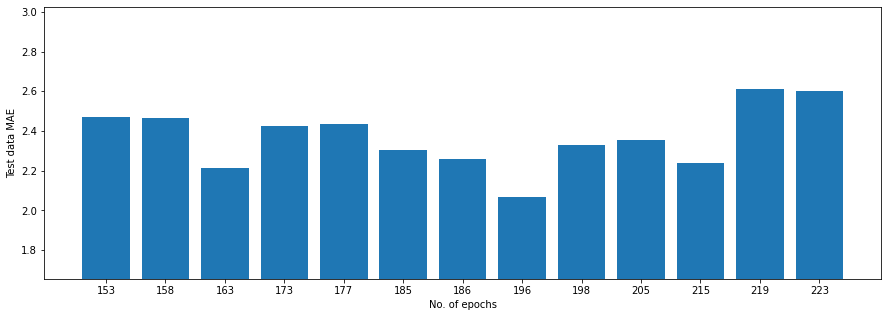

In [245]:
plot_MAE_for_epochs(build_model, [153,158,163,173,177,185,186,196,198,205,215,219,223])

Najlepszy wynik otrzymany do tej pory to MAE na poziomie 2069$ oraz loss równy 10.1239 przy epoce 196.